# Image Preprocessing
Steps of image preprocessing to improve conventional OCR outcome:

* [Normalization](#norm)
* [Skew correction](#skew)
* [Crop margins](#crop)


        data/
        ├── forms/    PDF forms
        ├── images/   PDF-pages converted to images
        ├── prepped/  preprocessed images
        ├── ...


In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import pytesseract as ts
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pathlib import Path
from PIL import Image

In [2]:
# local notebooks helper functions
from scripts import utils, prep

In [3]:
# samples of IRS and Canadian blank tax-slips
images = [str(x) for x in Path('./data/images').glob('*.png')]

# various noisy low-resolution scanned documents FUNSD dataset
#images = [str(x) for x in Path('./data/FUNSD/training_data/images').glob('*.png')]

In [4]:
if not os.path.exists('./data/prepped'):
    os.makedirs('./data/prepped')

### Utilities

In [5]:
def img_load(path: str) -> np.array:
    """
    load image data into numpy array 2d matrix -- we only need gray-scale
    """
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)


In [6]:
def img_resize(imgarr: np.array, scale: int = 2048) -> tuple:
    """
    upscale if low dpi: should have more than 300 pixel per inch
    """
    height, width = imgarr.shape
    factor = float(scale) / width
    if factor > 1:
        size = int(factor * width), int(factor * height)
        return cv2.resize(imgarr, size, interpolation = cv2.INTER_AREA), factor        
    return imgarr, factor


In [7]:
def img_rotate(imgarr: np.array, angle: float, fill=0) -> np.array:
    """
    rotate the grayscale image preserving all content (without cropping corners):
    resulting in the bigger size
    """
    height, width = imgarr.shape
    center = (width // 2, height // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # expand to accomodate corners
    radians = math.radians(angle)
    sin, cos = math.sin(radians), math.cos(radians)
    W = int((height * abs(sin)) + (width * abs(cos)))
    H = int((height * abs(cos)) + (width * abs(sin)))
    matrix[0, 2] += ((W/2) - center[0])
    matrix[1, 2] += ((H/2) - center[1])
    
    # rotate and fillup with margins backgroung
    return cv2.warpAffine(imgarr, matrix, (W, H), flags=cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_CONSTANT, borderValue=fill)


./data/images/que-RL-31.G-V.en-14.png


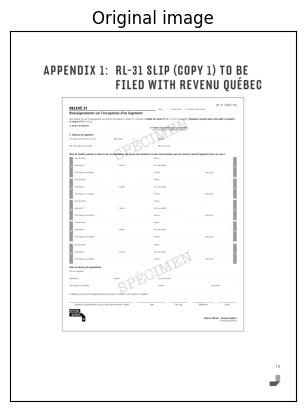

In [8]:
#source = np.random.choice(images)
source = './data/images/que-RL-31.G-V.en-14.png'
imgarr = img_load(source)
print(source)
utils.img_show(imgarr, 'Original image')

In [9]:
# accepted resolution
img_resize(imgarr)[0].shape

(2650, 2047)

<a name="norm"></a>
<h2>1. Normalization</h2>
The optimal scenario depends on the data.

In [10]:
def img_normalize(imgarr: np.array) -> np.array:
    """
    perform resampling, denoising, and range-normalization of pixel intensity values
    """
    output = imgarr.copy()    
    output, factor = img_resize(output)
    #output = cv2.fastNlMeansDenoising(output, None, 3, 7, 99)
    #output = cv2.normalize(output, None, 0, 1, cv2.NORM_MINMAX) * 255
    
    if factor > 1: # low-resolution
        kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
        for _ in range(3):
            output = cv2.GaussianBlur(output,(5, 5), 0)
            output = cv2.filter2D(output, ddepth=-1, kernel=kernel)            
    else: # high resolution
        output = cv2.erode(output, np.ones((2, 2), np.uint8), iterations=1)
    # binarize
    return cv2.threshold(output, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]




Original image: (2200, 1700)


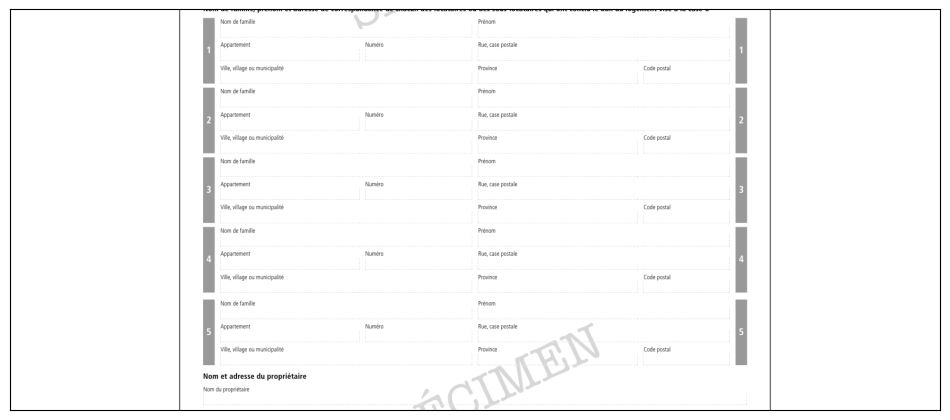


Normalized image: (2650, 2047)


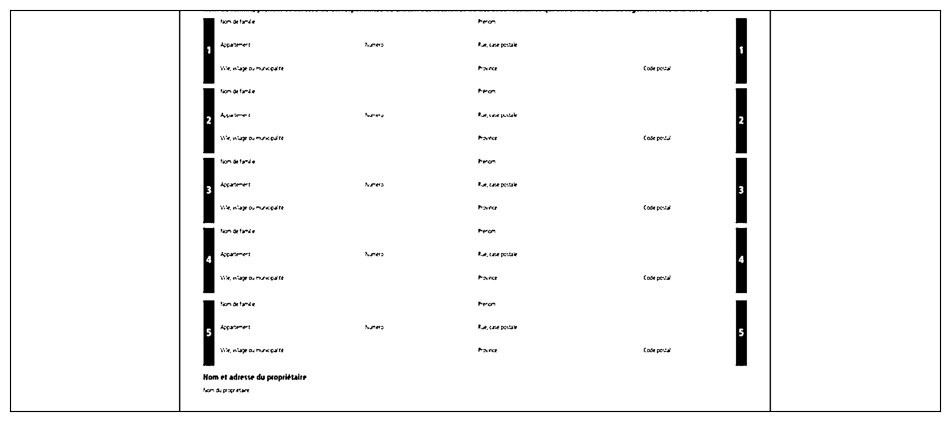

In [11]:
print('\n\nOriginal image:', imgarr.shape)
#utils.img_show(imgarr)
height, width = imgarr.shape
clip = slice(height//3, -height//3)
utils.img_show(imgarr[clip,:], hide_ticks=True, figsize=(12, 12))

normalized = img_normalize(imgarr)
print('\nNormalized image:', normalized.shape)
#utils.img_show(normalized)
height, width = normalized.shape
clip = slice(height//3, -height//3)
utils.img_show(255 - normalized[clip,:], hide_ticks=True, figsize=(12, 12))

# read the text from the original image
#data = pd.DataFrame.from_dict(ts.image_to_data(imgarr[clip,:], output_type=ts.Output.DICT))
#' '.join(data[data['text']!='']['text'].to_list())

In [12]:
# read the text from the normalized image
#data = pd.DataFrame.from_dict(ts.image_to_data(normalized, output_type=ts.Output.DICT))
#' '.join(data[data['text']!='']['text'].to_list())

<a name="skew"></a>
<h2>2. Skew correction</h2>
Scanned images might be skewed or flipped, we need the text run as close to horizontal right to left as possible.

In [13]:
def detect_skew(gray: np.array, max_angle: int = 10) -> int:
    """
    detect skew based on text; does not detect orientation
    """    
    def determine_score_pil(arr, angle):
        """
        this could be done with cv2 and scipy.ndimage
        PIL, however, delivered the fastest and better result
        """
        data = Image.fromarray(arr).rotate(angle)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    # sample original image down for faster execution as we do not need text here
    size = max(gray.shape)
    factor = min(256, size//4)/size
    size = tuple((np.array(gray.shape) * factor).astype(int))[::-1]
    test = cv2.resize(gray, size, interpolation=cv2.INTER_AREA)
    test = cv2.threshold(test, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    # score outcomes in the expected range
    scores = []
    angles = np.arange(-max_angle, max_angle + 1, 1)
    for angle in angles:
        histogram, score = determine_score_pil(test, angle)
        scores.append(score)
    # return the angle with best score
    return angles[scores.index(max(scores))]


In [14]:
# check whole range
result = []
for angle in range(1, 365, 7):
    angle += np.random.rand() * 3
    rotated = img_rotate(normalized, angle)
    detected = detect_skew(rotated, max_angle=45)
    correction = int(angle + detected)
    print(f'Skewed: {angle:.0f}deg -- detected: {detected:.0f}deg -- correction: {correction:.0f}')
    result.append(int(correction in [0, 1, 89, 90, 91, 179, 180, 181, 269, 270, 271, 359, 360]))
    
print(f'Correct: {sum(result)/len(result):.2%}')

Skewed: 4deg -- detected: -4deg -- correction: 0
Skewed: 9deg -- detected: -9deg -- correction: 0
Skewed: 18deg -- detected: -18deg -- correction: 0
Skewed: 23deg -- detected: -23deg -- correction: 0
Skewed: 30deg -- detected: -30deg -- correction: 0
Skewed: 37deg -- detected: -37deg -- correction: 0
Skewed: 44deg -- detected: -44deg -- correction: 0
Skewed: 51deg -- detected: 40deg -- correction: 90
Skewed: 58deg -- detected: 32deg -- correction: 90
Skewed: 67deg -- detected: 23deg -- correction: 89
Skewed: 73deg -- detected: 17deg -- correction: 90
Skewed: 80deg -- detected: 10deg -- correction: 89
Skewed: 86deg -- detected: 4deg -- correction: 90
Skewed: 95deg -- detected: -5deg -- correction: 89
Skewed: 101deg -- detected: -11deg -- correction: 90
Skewed: 108deg -- detected: -18deg -- correction: 90
Skewed: 114deg -- detected: -24deg -- correction: 90
Skewed: 122deg -- detected: -32deg -- correction: 89
Skewed: 128deg -- detected: -38deg -- correction: 90
Skewed: 135deg -- detected

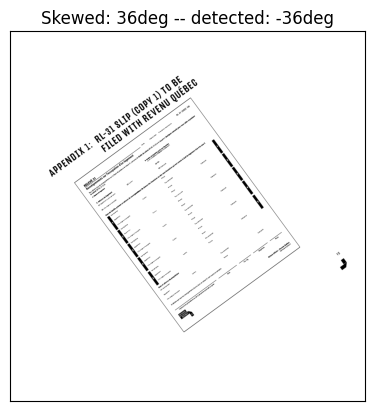

In [15]:
angle = np.random.rand() * 360
rotated = img_rotate(normalized, angle)
detected = detect_skew(rotated, max_angle=45)
utils.img_show(255 - rotated, f'Skewed: {angle:.0f}deg -- detected: {detected:.0f}deg')

In [16]:
# tesseract-osd detect orientation
ts.image_to_osd(rotated, output_type=ts.Output.DICT,
                config='-l osd --psm 0 -c min_characters_to_try=10')['rotate']

0

In [17]:
# check whole range
result = []
for orient in [0, 90, 180, 270]:
    for angle in range(orient - 6, orient + 6, 2):
        angle += np.random.rand() * 3
        test = img_rotate(normalized, angle)
        detected = ts.image_to_osd(test, output_type=ts.Output.DICT,
                                   config='-l osd --psm 0 -c min_characters_to_try=10')['rotate']
        print(f'Orientation: {orient} skew: {angle:.0f}deg -- detected: {detected:.0f}deg')
        result.append(int(abs(orient - detected) < 90))
        
print(f'Correct: {sum(result)/len(result):.2%}')        

Orientation: 0 skew: -4deg -- detected: 0deg
Orientation: 0 skew: -1deg -- detected: 180deg
Orientation: 0 skew: 0deg -- detected: 0deg
Orientation: 0 skew: 2deg -- detected: 0deg
Orientation: 0 skew: 2deg -- detected: 180deg
Orientation: 0 skew: 6deg -- detected: 0deg
Orientation: 90 skew: 86deg -- detected: 90deg
Orientation: 90 skew: 88deg -- detected: 270deg
Orientation: 90 skew: 89deg -- detected: 90deg
Orientation: 90 skew: 92deg -- detected: 90deg
Orientation: 90 skew: 93deg -- detected: 90deg
Orientation: 90 skew: 95deg -- detected: 90deg
Orientation: 180 skew: 174deg -- detected: 0deg
Orientation: 180 skew: 177deg -- detected: 180deg
Orientation: 180 skew: 181deg -- detected: 180deg
Orientation: 180 skew: 182deg -- detected: 180deg
Orientation: 180 skew: 182deg -- detected: 0deg
Orientation: 180 skew: 185deg -- detected: 0deg
Orientation: 270 skew: 267deg -- detected: 270deg
Orientation: 270 skew: 267deg -- detected: 0deg
Orientation: 270 skew: 270deg -- detected: 270deg
Orien

Note: `Tesseract 5.3.1` is not reliable even with sufficient text it fails a lot.

In [18]:
def img_deskew(imgarr: np.array, max_angle: int = 45) -> tuple:
    """
    Deskew package detects any rotation angle quite well but
    only returns the closest cardinal direction:
    between 0 and 45 deg, so we still have to handle cardinal flips
    Tesseract-osd only handles cardinal flips (90, 180)
        
    Correction is driven by text presence and orientation:
    will fail if no text available

    Args:
        imgarr (np.array): 2d matrix

    Returns:
        tuple: 2d matrix (fixed image), detected angle (skew)
    """
    angle = detect_skew(imgarr, max_angle=max_angle)
    if angle != 0:
        aligned = img_rotate(imgarr, angle)
    else:
        aligned = imgarr.copy()
    try:
        osd = ts.image_to_osd(aligned, output_type=ts.Output.DICT,
                              config='-l osd --psm 0 -c min_characters_to_try=10')
    except Exception as e:
        logging.info(f'failed osd: {e}')
        return None, -int(round(angle))

    if osd['rotate'] != 0:
        flip = -osd['rotate']
        aligned = img_rotate(aligned, flip)
        return aligned, -int(round(angle + flip))
    
    return aligned, -int(round(angle))


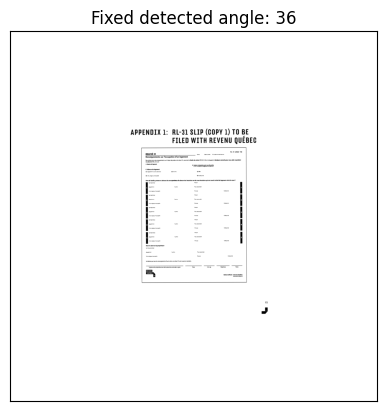

In [19]:
aligned, angle = img_deskew(rotated)
utils.img_show(255 - aligned, f'Fixed detected angle: {angle}')

<a name="crop"></a>
<h2>3. Crop margins</h2>

To normalize header/footer location we might need to crop extra white space from the sides. This works well for images coming from convering pdf-files (clean). To remove colored margins from the sides of scanned forms we use different (variance-based) algorithm in `prep.img_crop_margins` function.

In [20]:
def img_crop_margins(imgarr: np.array, pad: int = 10) -> np.array:
    """
    Remove extra space from the sides:
    sometimes we need extract text from the header/footer areas only
    """
    imgarr = cv2.normalize(imgarr, np.zeros(imgarr.shape), 0, 255, cv2.NORM_MINMAX)
    output = 255 * (imgarr >= 128).astype(np.uint8)
    output = cv2.morphologyEx(output, cv2.MORPH_OPEN, np.ones(2, dtype=np.uint8))
    coords = cv2.findNonZero(output)
    x, y, w, h = cv2.boundingRect(coords)
    H, W = imgarr.shape
    return imgarr[max(0, y - pad):min(H + 1, y + h + pad), max(0, x - pad):min(W + 1, x + w + pad)]


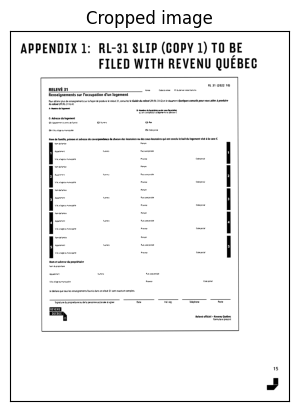

In [21]:
# padding based on the dpi we expect to have here
pad = max(32, max(aligned.shape) >> 6)

cropped = img_crop_margins(aligned, pad)
utils.img_show(255 - cropped, 'Cropped image')

### Deployment code
To use in our application the functions from this notebook we collected in the `prep` module.

In [22]:
# run basic functionality tests
!python scripts/test_prep.py

.......
----------------------------------------------------------------------
Ran 7 tests in 1.107s

OK


In [23]:
# run with commandline
#!python scripts/prep.py 'source_path.png' 'output_path.png'
#!python scripts/prep.py './data/images/que-RL-31.G-V.en-14.png' './data/prepped/que-RL-31.G-V.en-14.png'